# SNA
## Android malware detector

Authors:
- Nguyen Minh Tuan
- Le Dinh Nam
- Nguyen Thai Hung

In this part we reuse some of the previous codes used to train some of the models as well as finding the optimal threshold.

## Task 4
<font color='gray'>Instead of using the processed features, go back to the raw features and figure out another way of using them to produce feature vectors that are not counts of the feature families, yet amenable to machine learning classifiers, and repeat Task 3. In addition, you should conduct feature selection, that is, you should study the importance of each of the features you suggested and take out features that do not seem to contribute much. Once more, you need to explain and justify your choices throughout the task and interpret the results adequately.</font>

In [ ]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# necessary paths
feature_of_counts = "./data/processed_data/new_transformation.csv"

# Random Seed for reproducible experiments
RS = 42
np.random.seed(RS)

In [ ]:
# data exploration
dataset = pd.read_csv(feature_of_counts, index_col=0)
display(dataset.head())

,access_network_state,action,activity,admob,android,api,api_call,app,call,category,...,org,permission,read_phone_state,real_permission,schemas,service_receiver,touchscreen,twitter,url,malware
0,0.073722,0.093886,0.305434,0.094639,0.390947,0.000000,0.074731,0.040295,0.127188,0.047015,...,0.0,0.148136,0.00000,0.050410,0.080769,0.090816,0.023049,0.0,0.499276,False
1,0.000000,0.033421,0.033454,0.000000,0.622147,0.000000,0.106407,0.000000,0.144879,0.033471,...,0.0,0.457008,0.12134,0.107665,0.000000,0.000000,0.032819,0.0,0.355452,False
2,0.000000,0.083183,0.249796,0.000000,0.489001,0.000000,0.176563,0.142803,0.090150,0.083309,...,0.0,0.087498,0.00000,0.089325,0.000000,0.000000,0.081686,0.0,0.491505,False
3,0.000000,0.027695,0.055445,0.614180,0.407026,0.120235,0.088178,0.000000,0.120060,0.027737,...,0.0,0.233057,0.00000,0.059481,0.095303,0.053579,0.027197,0.0,0.360017,False
4,0.000000,0.099619,0.498588,0.000000,0.585623,0.000000,0.105725,0.171019,0.107963,0.099770,...,0.0,0.104787,0.00000,0.106975,0.000000,0.192721,0.097826,0.0,0.000000,False


In [ ]:
num_beningware = len(dataset[dataset['malware'] == False])
num_malware = len(dataset[dataset['malware'] == True])

print("Number of Benignware:", num_beningware)
print("Number of Malware:", num_malware)

Number of Benignware: 123453
Number of Malware: 5560


In [ ]:
# Undersampling

benigware_indices = dataset[dataset.malware == False].index
benigware_indices_to_drop = np.random.choice(benigware_indices, num_beningware - num_malware, replace=False)
dataset = dataset.drop(benigware_indices_to_drop)

num_beningware = len(dataset[dataset['malware'] == False])
num_malware = len(dataset[dataset['malware'] == True])

print("Number of Benignware:", num_beningware)
print("Number of Malware:", num_malware)

Number of Benignware: 5560
Number of Malware: 5560


In [ ]:
X = dataset.drop(columns=['malware'])
y = dataset['malware']

display(X.head(5))
display(y.head(5))

,access_network_state,action,activity,admob,android,api,api_call,app,call,category,...,net,org,permission,read_phone_state,real_permission,schemas,service_receiver,touchscreen,twitter,url
12,0.096561,0.030743,0.061547,0.000000,0.542183,0.000000,0.130510,0.000000,0.199909,0.030790,...,0.083852,0.000000,0.452734,0.111619,0.132053,0.000000,0.000000,0.030190,0.0,0.399637
30,0.024341,0.015500,0.023272,0.000000,0.447989,0.134579,0.098698,0.026609,0.067191,0.015523,...,0.063413,0.017881,0.497263,0.028137,0.091543,0.000000,0.134934,0.007610,0.0,0.384648
48,0.000000,0.075717,0.075793,0.000000,0.667674,0.000000,0.080359,0.000000,0.164119,0.075833,...,0.000000,0.000000,0.557521,0.137454,0.081309,0.000000,0.000000,0.074355,0.0,0.000000
58,0.134557,0.042840,0.085765,0.172735,0.629605,0.000000,0.136398,0.073545,0.185714,0.042905,...,0.058424,0.000000,0.450628,0.000000,0.092008,0.147419,0.000000,0.042069,0.0,0.303758
63,0.028464,0.009062,0.063499,0.036540,0.355161,0.000000,0.086560,0.015558,0.108035,0.009076,...,0.024718,0.000000,0.247845,0.032903,0.077852,0.046777,0.000000,0.008899,0.0,0.685400


12     True
30     True
48     True
58    False
63    False
Name: malware, dtype: bool

In [ ]:
# split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RS)

# preprocess data
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [ ]:
# evaluation metrics
def print_metrics(y_test, predicted):
	print("acc       {:.4}".format(metrics.accuracy_score(y_test, predicted)))
	print("f1        {:.4}".format(metrics.f1_score(y_test, predicted)))
	print("precision {:.4}".format(metrics.precision_score(y_test, predicted)))
	print("recall    {:.4}".format(metrics.recall_score(y_test, predicted)))


In [ ]:
# confusion matrix
def plot_conf_mat(y_test, predicted):
	conf_mat = metrics.confusion_matrix(y_test, predicted)

	# https://proclusacademy.com/blog/practical/confusion-matrix-accuracy-sklearn-seaborn/
	# Change figure size and increase dpi for better resolution
	plt.figure(figsize=(8,6), dpi=100)
	# Scale up the size of all text
	params = {"ytick.color" : "w", "xtick.color" : "w","axes.labelcolor" : "w","axes.edgecolor" : "w"}
	plt.rcParams.update(params)
	sns.set(font_scale = 1.1)

	# Plot Confusion Matrix using Seaborn heatmap()
	# Parameters:
	# first param - confusion matrix in array format
	# annot = True: show the numbers in each heatmap cell
	# fmt = 'd': show numbers as integers.
	ax = sns.heatmap(conf_mat, annot=True, fmt='d', )

	# set x-axis label and ticks.
	ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
	ax.xaxis.set_ticklabels(['Negative', 'Positive'])

	# set y-axis label and ticks
	ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
	ax.yaxis.set_ticklabels(['Negative', 'Positive'])

	# set plot title
	ax.set_title("Confusion Matrix", fontsize=14, pad=20)

	plt.show()

Models chosen from task 2:
1. DecisionTree,
1. SVC,
1. LogisticRegression,
1. RidgeClassifier,
1. KNeighborsClassifier

In [ ]:
CV_SPLITS = 5
models = {}

In [ ]:
def get_best_estimator(
	estimator: BaseEstimator,
	params_grid: dict,
	X: pd.DataFrame,
	y: pd.Series
):
	clf = GridSearchCV(
		estimator=estimator,
		param_grid=params_grid,
		cv=KFold(n_splits=CV_SPLITS, shuffle=True, random_state=RS),
		n_jobs=5,
		scoring='roc_auc',
		return_train_score=True
	)

	clf.fit(X, y)

	print(f'Hyperparameters found:')
	display(clf.best_params_)
	print(f'Best score: {clf.best_score_:.4}')

	return {'clf': clf.best_estimator_, 'auc': clf.best_score_, 'params': clf.best_params_}

To not re-train the models every time we run the notebook, we decided to save the best models to .pkl files.

In [ ]:
models_path = "./models/"

def try_to_load_model(name: str):
    if os.path.exists(f'{models_path}{name}.pkl'):
        with open(f'{models_path}{name}.pkl', 'rb') as f:
            model_data = pickle.load(f)
            print(f'Loaded {name} model from file')
            print(f'Hyperparameters:')
            display(model_data["params"])
            print(f'Best score: {model_data["auc"]:.4}')
            return model_data
    else:
        print(f'No {name} model found')
        return None

def save_model(name: str, model):
    print(f'Saving {name} model to file')
    with open(f'{models_path}{name}.pkl', 'wb') as f:
        pickle.dump(model, f)

### [Decision Tree](https://scikit-learn.org/stable/modules/tree.html)

In [ ]:
NAME = 'DecisionTree'

models[NAME] = try_to_load_model(NAME)

if models[NAME] is None:
    print(f'Training {NAME} model')

    params_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 4, 8, 12, 16, 20],
        'max_features': [None, 0.2, 0.4, 0.6, 0.8],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32],
        'min_samples_split': [2, 4, 8, 16, 32],
    }

    models[NAME] = {
        **get_best_estimator(
            estimator=DecisionTreeClassifier(random_state=RS),
            params_grid=params_grid,
            X=X_train, # don't have to be scaled
            y=y_train
        ),
        'scaled': False
    }

    save_model(NAME, models[NAME])

Loaded DecisionTree model from file
Hyperparameters:


{'criterion': 'entropy',
 'max_depth': 12,
 'max_features': 0.8,
 'min_samples_leaf': 8,
 'min_samples_split': 32}

Best score: 0.9535


### [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

In [ ]:
NAME = 'SVC'

models[NAME] = try_to_load_model(NAME)

if models[NAME] is None:
    print(f'Training {NAME} model')

    params_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    }

    models[NAME] = {
        **get_best_estimator(
            estimator=SVC(random_state=RS),
            params_grid=params_grid,
            X=X_train_scaled, # should be scaled
            y=y_train
        ),
        'scaled': True
    }

    save_model(NAME, models[NAME])

Loaded SVC model from file
Hyperparameters:


{'C': 10, 'kernel': 'rbf'}

Best score: 0.9767


### [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [ ]:
NAME = 'LogisticRegression'

models[NAME] = try_to_load_model(NAME)

if models[NAME] is None:
    print(f'Training {NAME} model')

    params_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 300, 500],
        'solver': ['newton-cg', 'liblinear', 'lbfgs']
    }

    models[NAME] = {
        **get_best_estimator(
            estimator=LogisticRegression(random_state=RS, n_jobs=-1),
            params_grid=params_grid,
            X=X_train_scaled, # should be scaled
            y=y_train
        ),
        'scaled': True
    }

    save_model(NAME, models[NAME])

Loaded LogisticRegression model from file
Hyperparameters:


{'C': 1, 'solver': 'lbfgs'}

Best score: 0.9416


### [RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier)

In [ ]:
NAME = 'RidgeClassifier'

models[NAME] = try_to_load_model(NAME)

if models[NAME] is None:
    print(f'Training {NAME} model')

    params_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    }

    models[NAME] = {
        **get_best_estimator(
            estimator=RidgeClassifier(random_state=RS),
            params_grid=params_grid,
            X=X_train, # don't have to be scaled
            y=y_train
        ),
        'scaled': False
    }

    save_model(NAME, models[NAME])

Loaded RidgeClassifier model from file
Hyperparameters:


{'alpha': 0.001}

Best score: 0.9375


### [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

In [ ]:
NAME = 'KNeighborsClassifier'

models[NAME] = try_to_load_model(NAME)

if models[NAME] is None:
    print(f'Training {NAME} model')

    params_grid = {
        'n_neighbors': [3, 7, 11, 15],
        'weights': ['uniform', 'distance'],
        'p': [1]
    }

    models[NAME] = {
        **get_best_estimator(
            estimator=KNeighborsClassifier(n_jobs=-1),
            params_grid=params_grid,
            X=X_train, # don't have to be scaled
            y=y_train
        ),
        'scaled': False
    }

    save_model(NAME, models[NAME])

No KNeighborsClassifier model found
Training KNeighborsClassifier model
Hyperparameters found:


{'n_neighbors': 15, 'p': 1, 'weights': 'distance'}

Best score: 0.9742
Saving KNeighborsClassifier model to file


### Best of all
As we may see below, the results are slightly different to the previous ones. This time, SVC is the best model outperforming KNeighborsClassifier. However, this can be also due to the fact that we disabled too many neighbors for this model.

In [ ]:
best = {}

for name, model_data in models.items():
	print(f"{name}: {model_data['auc']:.4}")

	if model_data['auc'] > best.get('auc', 0):
		best = model_data
		best['name'] = name

print(f"Best model: {best['name']}")

DecisionTree: 0.9535
SVC: 0.9767
LogisticRegression: 0.9416
RidgeClassifier: 0.9375
KNeighborsClassifier: 0.9742
Best model: SVC


acc       0.9483
f1        0.9472
precision 0.9425
recall    0.952


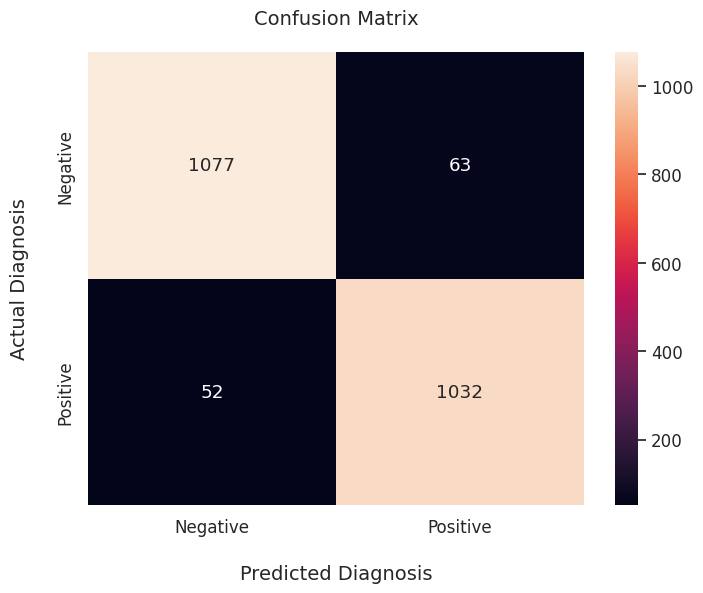

In [ ]:
predicted = best['clf'].predict(X_test_scaled if best['scaled'] else X_test)

print_metrics(y_test, predicted)
plot_conf_mat(y_test, predicted)